In [1]:
import pyspiel
import open_spiel.python.games
from open_spiel.python import policy
from open_spiel.python.pytorch import deep_cfr
from open_spiel.python.algorithms import expected_game_score
from open_spiel.python.algorithms import exploitability


# 1. Kuhn Poker

In [10]:

game = pyspiel.load_game("kuhn_poker")

deep_cfr_solver = deep_cfr.DeepCFRSolver(
    game,
    policy_network_layers=(32, 32, 32),
    advantage_network_layers=(16, 16, 16),
    num_iterations= 1000,
    num_traversals= 40,
    learning_rate=1e-3,
    batch_size_advantage=None,
    batch_size_strategy=None,
    memory_capacity=int(1e7))

# _, advantage_losses, policy_loss = deep_cfr_solver.solve()


In [3]:
print(_)
print("Advantage losses: ", advantage_losses)
print("Policy loss: ", policy_loss)

MLP(
  (model): ModuleList(
    (0-3): 4 x SonnetLinear()
  )
)
Advantage losses:  defaultdict(<class 'list'>, {0: [array(1.0858625, dtype=float32), array(1.8034267, dtype=float32), array(3.0089927, dtype=float32), array(5.5441613, dtype=float32), array(6.028208, dtype=float32), array(6.673054, dtype=float32), array(8.808755, dtype=float32), array(8.719536, dtype=float32), array(8.590936, dtype=float32), array(8.658683, dtype=float32), array(8.624969, dtype=float32), array(8.865556, dtype=float32), array(9.553616, dtype=float32), array(9.831572, dtype=float32), array(11.951506, dtype=float32), array(14.150753, dtype=float32), array(16.61902, dtype=float32), array(18.313967, dtype=float32), array(17.179195, dtype=float32), array(17.827732, dtype=float32), array(18.65436, dtype=float32), array(20.480944, dtype=float32), array(22.102776, dtype=float32), array(21.87944, dtype=float32), array(22.381287, dtype=float32), array(23.460842, dtype=float32), array(24.241747, dtype=float32), array(

In [5]:
for player, losses in advantage_losses.items():
    print(f"Advantage for player {player}: {losses[:2] + ['...'] + losses[-2:]}")
    print(f"Advantage Buffer Size for player {player}: '{len(deep_cfr_solver.advantage_buffers[player])}'")
print(f"Strategy Buffer Size: '{len(deep_cfr_solver.strategy_buffer)}'")
print(f"Final policy loss: '{policy_loss}'")

average_policy = policy.tabular_policy_from_callable(
    game, deep_cfr_solver.action_probabilities)
pyspiel_policy = policy.python_policy_to_pyspiel_policy(average_policy)
conv = pyspiel.nash_conv(game, pyspiel_policy)
print(f"Deep CFR in 'kuhn_poker' - NashConv: {conv}")

average_policy_values = expected_game_score.policy_value(
    game.new_initial_state(), [average_policy] * 2)
print(f"Computed player 0 value: {average_policy_values[0]:.2f} (expected: {-1 / 18:.2f}).")
print(f"Computed player 1 value: {average_policy_values[1]:.2f} (expected: {1 / 18:.2f}).")

Advantage for player 0: [array(1.0858625, dtype=float32), array(1.8034267, dtype=float32), '...', array(284.8286, dtype=float32), array(289.52072, dtype=float32)]
Advantage Buffer Size for player 0: '24399'
Advantage for player 1: [array(0.79255384, dtype=float32), array(2.6223629, dtype=float32), '...', array(333.38074, dtype=float32), array(311.27988, dtype=float32)]
Advantage Buffer Size for player 1: '16000'
Strategy Buffer Size: '55550'
Final policy loss: '41.359100341796875'
Deep CFR in 'kuhn_poker' - NashConv: 0.8247051450094822
Computed player 0 value: 0.09 (expected: -0.06).
Computed player 1 value: -0.09 (expected: 0.06).


## Understanding the computed values

In [6]:
import collections
from open_spiel.python.algorithms import expected_game_score

def online_solve(self):
    """Modified deep-cfr solution logic for online policy evaluation"""
    advantage_losses = collections.defaultdict(list)
    for _ in range(self._num_iterations):
        for p in range(self._num_players):
            for _ in range(self._num_traversals):
                self._traverse_game_tree(self._root_node, p)
            if self._reinitialize_advantage_networks:
                # Re-initialize advantage network for player and train from scratch.
                self.reinitialize_advantage_network(p)
            advantage_losses[p].append(self._learn_advantage_network(p))
        self._iteration += 1
    # Train policy network.
    policy_loss = self._learn_strategy_network()
    return self._policy_network, advantage_losses, policy_loss


Iteration: 0 NashConv: 0.9579474896072651
Iteration: 100 NashConv: 1.0080265618574398
Iteration: 200 NashConv: 1.0260588710806773
Iteration: 300 NashConv: 1.0085213983362884
Iteration: 400 NashConv: 1.048478186420774
Iteration: 500 NashConv: 1.035946759717643
Iteration: 600 NashConv: 1.0058200973294333
Iteration: 700 NashConv: 1.0149251931563614
Iteration: 800 NashConv: 0.992684325690647
Iteration: 900 NashConv: 0.9658517472555467


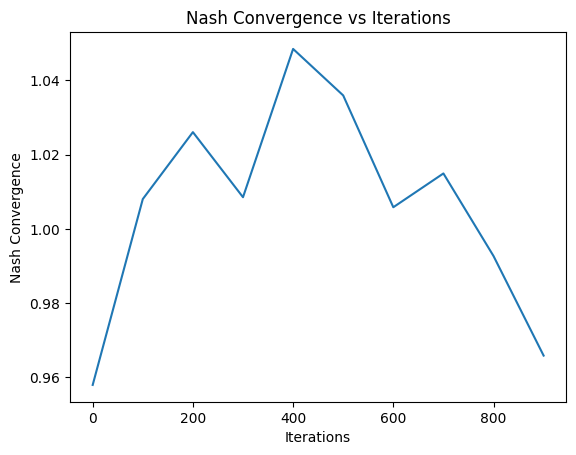

In [11]:
import matplotlib.pyplot as plt

# Initialize lists to store iteration numbers and Nash Convergence values
iterations = []
nash_convergences = []

advantage_losses = collections.defaultdict(list)
for i in range(deep_cfr_solver._num_iterations):
    if i % 100 == 0:
        average_policy = policy.tabular_policy_from_callable(
            game, deep_cfr_solver.action_probabilities)
        conv = exploitability.nash_conv(game, average_policy)

        print ("Iteration: {} NashConv: {}".format(i, conv))

        # Store iteration number and Nash Convergence value
        iterations.append(i)
        nash_convergences.append(conv)

    for p in range(deep_cfr_solver._num_players):
        for _ in range(deep_cfr_solver._num_traversals):
            deep_cfr_solver._traverse_game_tree(
                deep_cfr_solver._root_node, p)
        if deep_cfr_solver._reinitialize_advantage_networks:
            # Re-initialize advantage network for player and train from scratch.
            deep_cfr_solver.reinitialize_advantage_network(p)
        advantage_losses[p].append(
            deep_cfr_solver._learn_advantage_network(p))

    # Train policy network.
    policy_loss = deep_cfr_solver._learn_strategy_network()
    deep_cfr_solver._iteration += 1

# Create plot
plt.plot(iterations, nash_convergences)
plt.xlabel('Iterations')
plt.ylabel('Nash Convergence')
plt.title('Nash Convergence vs Iterations')
plt.show()

In [6]:
game = pyspiel.load_game("python_block_dominoes")
deep_cfr_solver = deep_cfr.DeepCFRSolver(
    game,
    policy_network_layers=(32, 32, 32),
    advantage_network_layers=(16, 16, 16),
    num_iterations= 100,
    num_traversals= 40,
    learning_rate=1e-3,
    batch_size_advantage=None,
    batch_size_strategy=None,
    memory_capacity=int(1e7))


In [7]:
policy_network, advantage_losses, policy_loss = deep_cfr_solver.solve()

KeyboardInterrupt: 

In [ ]:
print("Policy network: ", policy_network)
print("Policy loss: ", policy_loss)
print("Advantage losses: ", advantage_losses)

In [ ]:
for player, losses in advantage_losses.items():
    print("Player", player, "losses", losses)